In [ ]:
import os, random, time
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import timm
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model

from sklearn.metrics import accuracy_score, classification_report

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

OBJECTS = [
    "bottle","cable","capsule","carpet","grid",
    "hazelnut","leather","metal_nut","pill","screw",
    "tile","toothbrush","transistor","wood","zipper"
]
NUM_CLASSES = len(OBJECTS)

Mounted at /content/drive


In [ ]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.samples = []
        self.transform = transform

        for label, obj in enumerate(OBJECTS):
            base = root / obj / split
            if not base.exists():
                continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

In [ ]:
train_ds = MVTecObjectDataset(MVTEC_ROOT, "train", train_tfms)
test_ds  = MVTecObjectDataset(MVTEC_ROOT, "test",  test_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

Train: 3630 | Test: 1725


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_encoder.eval()

for p in text_encoder.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

In [ ]:
vit = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=0
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv"],
    lora_dropout=0.05
)

vit = get_peft_model(vit, lora_cfg).to(DEVICE)

In [ ]:
img_proj = nn.Linear(
    vit.model.num_features,
    txt_feat.shape[1]
).to(DEVICE)

logit_scale = nn.Parameter(
    torch.ones([]) * np.log(1 / 0.07)
)

In [ ]:
optimizer = torch.optim.AdamW(
    list(vit.parameters()) +
    list(img_proj.parameters()) +
    [logit_scale],
    lr=1e-4,
    weight_decay=0.01
)

criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    vit.train()
    img_proj.train()

    total_loss = 0.0
    loop = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, labels in loop:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = feat @ txt_feat.T * logit_scale.exp()
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_dl):.4f}")

Epoch 1/3: 100%|██████████| 114/114 [25:29<00:00, 13.42s/it, loss=1.26]


Epoch 1 | Train Loss: 1.6839


Epoch 2/3: 100%|██████████| 114/114 [02:43<00:00,  1.43s/it, loss=1.31]


Epoch 2 | Train Loss: 1.3196


Epoch 3/3: 100%|██████████| 114/114 [02:44<00:00,  1.44s/it, loss=1.58]

Epoch 3 | Train Loss: 1.2935


In [ ]:
vit.eval()
img_proj.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_dl, desc="Evaluating"):
        imgs = imgs.to(DEVICE)

        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = feat @ txt_feat.T
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

Evaluating: 100%|██████████| 54/54 [12:56<00:00, 14.38s/it]


In [ ]:
acc = accuracy_score(all_labels, all_preds)
print(f"\n ViT-B + LoRA Accuracy: {acc*100:.2f}%\n")

print(
    classification_report(
        all_labels,
        all_preds,
        target_names=OBJECTS,
        digits=4
    )
)


 ViT-B + LoRA Accuracy: 95.83%

              precision    recall  f1-score   support

      bottle     1.0000    0.9880    0.9939        83
       cable     1.0000    0.9867    0.9933       150
     capsule     1.0000    1.0000    1.0000       132
      carpet     1.0000    1.0000    1.0000       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9829    1.0000    0.9914       115
        pill     1.0000    0.5928    0.7444       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    0.9915    0.9957       117
  toothbrush     0.3784    1.0000    0.5490        42
  transistor     0.9901    1.0000    0.9950       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9583      1725
   macro avg     0.9568    0.9706    0.9508    

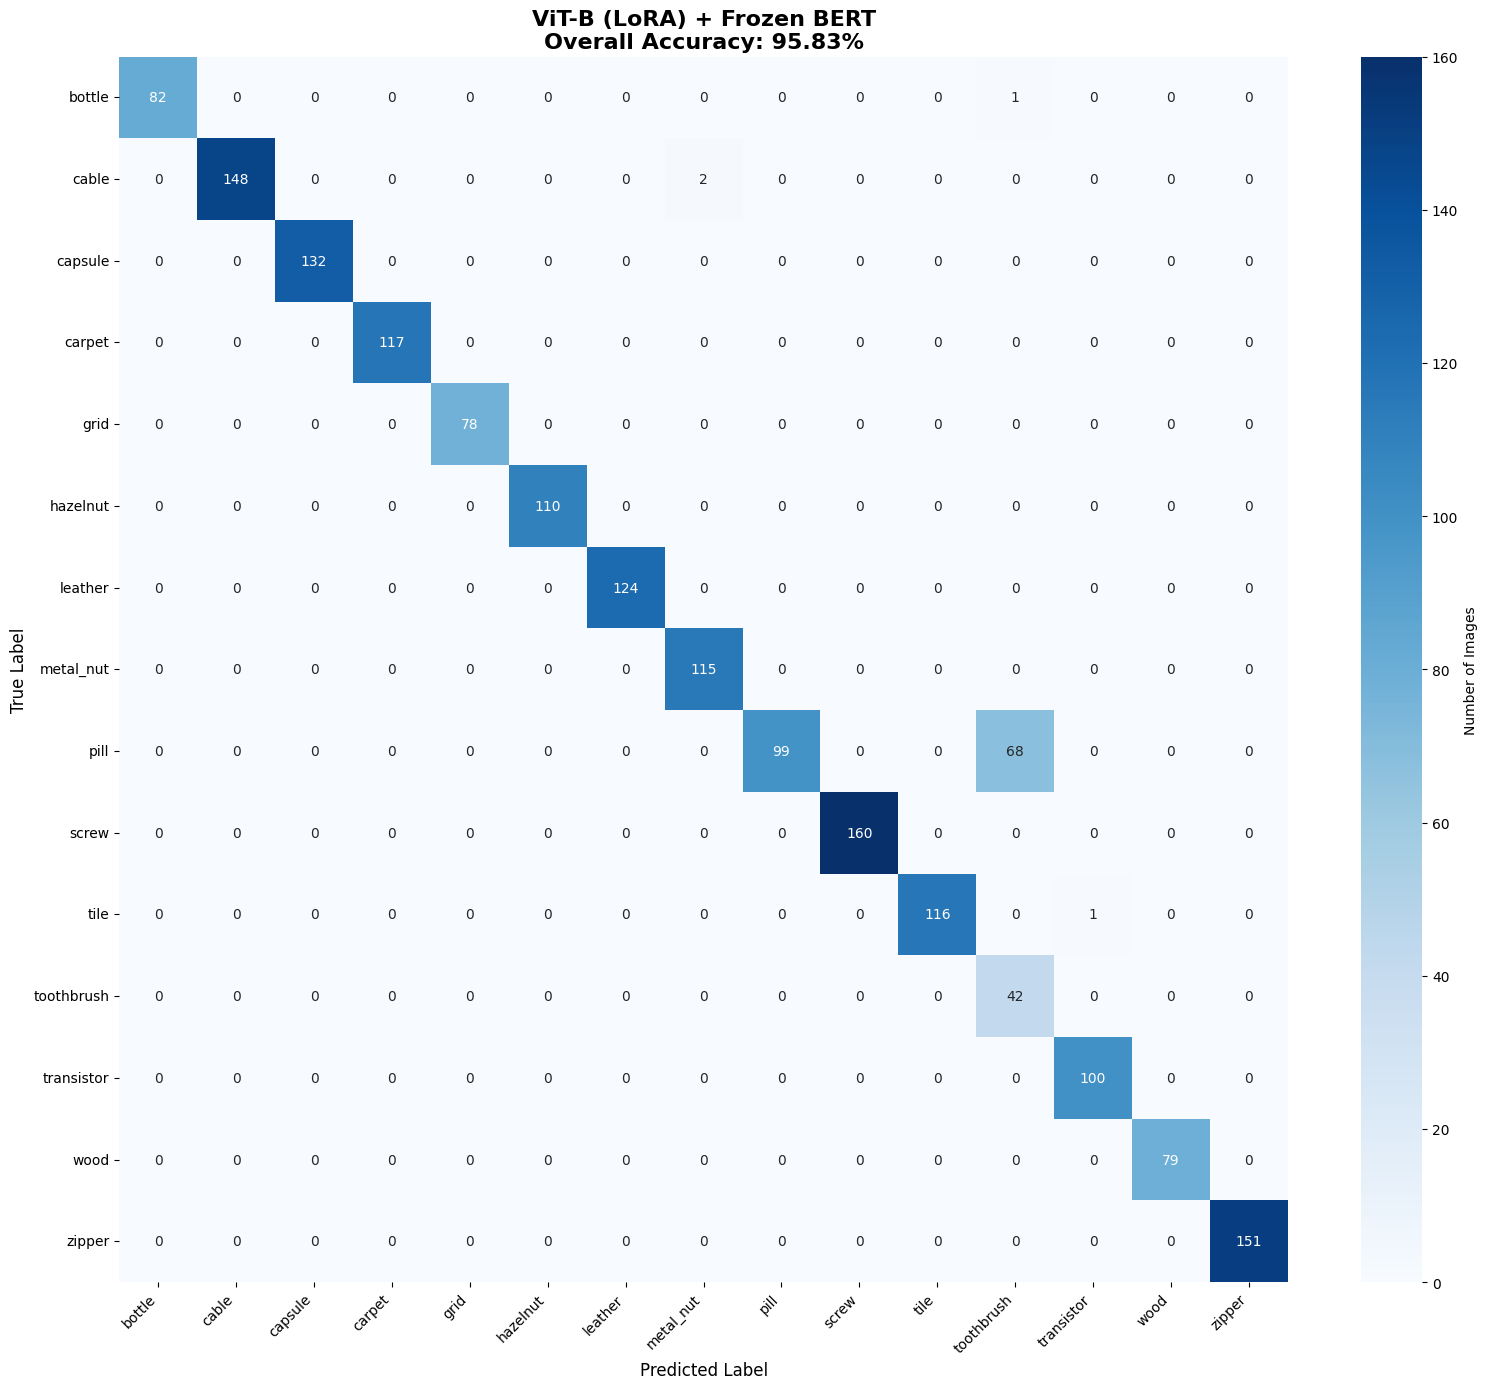

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Blues",
    cbar_kws={'label': 'Number of Images'}
)

plt.title(f"ViT-B (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

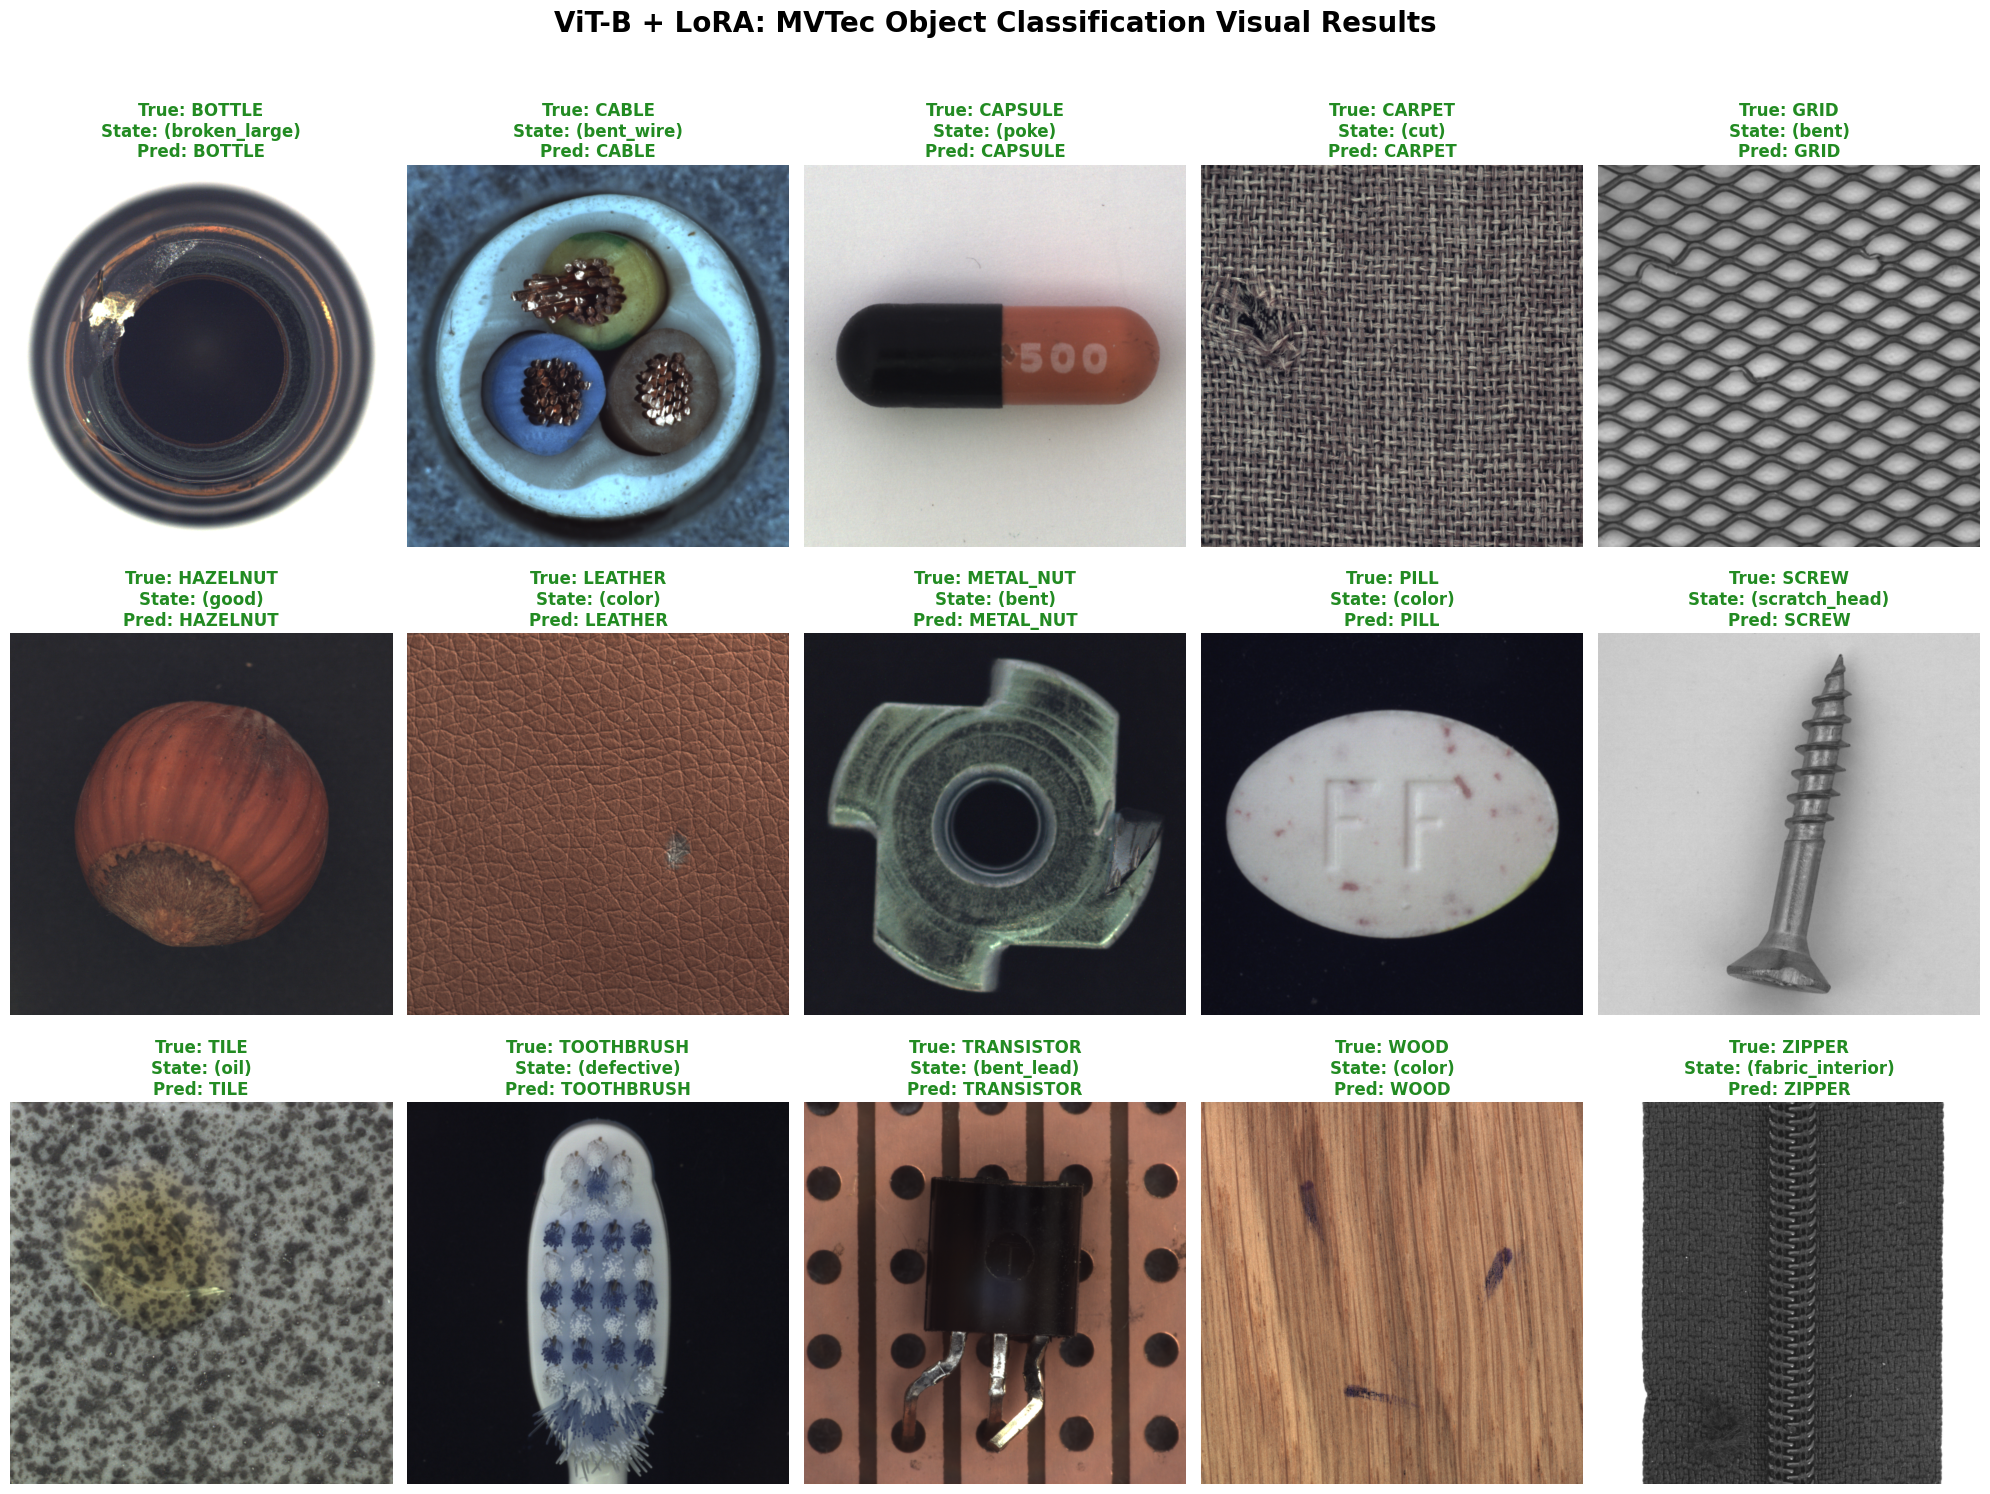

In [ ]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch

vit.eval()
img_proj.eval()

class_examples = {}
for obj in OBJECTS:
    test_path = MVTEC_ROOT / obj / "test"
    all_imgs = list(test_path.glob("**/*.png"))
    if all_imgs:
        class_examples[obj] = str(all_imgs[0])

plt.figure(figsize=(20, 15))
sorted_keys = sorted(class_examples.keys())

with torch.no_grad():
    for i, class_name in enumerate(sorted_keys):
        img_path = class_examples[class_name]
        img = Image.open(img_path).convert("RGB")
        defect_label = Path(img_path).parent.name

        img_t = test_tfms(img).unsqueeze(0).to(DEVICE)

        img_feat = vit(img_t)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T * logit_scale.exp()
        pred_idx = sims.argmax(1).item()
        pred_name = OBJECTS[pred_idx]

        is_correct = class_name.lower() == pred_name.lower()
        color = "forestgreen" if is_correct else "crimson"

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {class_name.upper()}\n"
            f"State: ({defect_label})\n"
            f"Pred: {pred_name.upper()}",
            color=color,
            fontsize=12,
            fontweight="bold"
        )
        plt.axis("off")

plt.suptitle(
    "ViT-B + LoRA: MVTec Object Classification Visual Results",
    fontsize=20, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

In [ ]:
!pip install fvcore
import torch
import torch.nn as nn
import time
from fvcore.nn import FlopCountAnalysis, flop_count_table
from sklearn.metrics import accuracy_score

class InferenceModule(nn.Module):
    def __init__(self, vit_model, proj_layer, logit_scale):
        super().__init__()
        self.vit = vit_model
        self.proj = proj_layer
        self.logit_scale = logit_scale

    def forward(self, x):
        with torch.no_grad():
            feat = self.vit(x)
            feat = self.proj(feat)
            feat = feat / feat.norm(dim=1, keepdim=True)
            return feat * self.logit_scale.exp()

model_to_profile = InferenceModule(vit, img_proj, logit_scale).eval().to(DEVICE)

dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

flops = FlopCountAnalysis(model_to_profile, dummy_input)
flops.unsupported_ops_warnings(False)

total_flops = flops.total()
gflops = total_flops / 1e9
gmacs = (total_flops / 2) / 1e9

for _ in range(10):
    _ = model_to_profile(dummy_input)

start_time = time.time()
iterations = 100
for _ in range(iterations):
    _ = model_to_profile(dummy_input)
latency = ((time.time() - start_time) / iterations) * 1000  # ms
throughput = 1000 / latency  # images/sec

vit.eval()
img_proj.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)
        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)
        logits = feat @ txt_feat.T * logit_scale.exp()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc_val = accuracy_score(all_labels, all_preds)

efficiency = (acc_val * 100) / gflops

print("="*45)
print(f"{'INFERENCE METRIC':<25} | {'VALUE':<15}")
print("-" * 45)
print(f"{'Total GFLOPs':<25} | {gflops:.4f}")
print(f"{'Total GMACs':<25} | {gmacs:.4f}")
print(f"{'Latency (GPU)':<25} | {latency:.2f} ms")
print(f"{'Throughput (FPS)':<25} | {throughput:.2f} images/s")
print(f"{'Accuracy':<25} | {acc_val*100:.2f}%")
print(f"{'Acc per GFLOP':<25} | {efficiency:.4f}")
print("-" * 45)

vit.base_model.model.blocks.0.attn.attn_drop, vit.base_model.model.blocks.1.attn.attn_drop, vit.base_model.model.blocks.10.attn.attn_drop, vit.base_model.model.blocks.11.attn.attn_drop, vit.base_model.model.blocks.2.attn.attn_drop, vit.base_model.model.blocks.3.attn.attn_drop, vit.base_model.model.blocks.4.attn.attn_drop, vit.base_model.model.blocks.5.attn.attn_drop, vit.base_model.model.blocks.6.attn.attn_drop, vit.base_model.model.blocks.7.attn.attn_drop, vit.base_model.model.blocks.8.attn.attn_drop, vit.base_model.model.blocks.9.attn.attn_drop


INFERENCE METRIC          | VALUE          
---------------------------------------------
Total GFLOPs              | 16.9834
Total GMACs               | 8.4917
Latency (GPU)             | 21.70 ms
Throughput (FPS)          | 46.09 images/s
Accuracy                  | 95.83%
Acc per GFLOP             | 5.6423
---------------------------------------------


In [ ]:
import torch
import time
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/Final-VitB")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

final_train_time = train_time if 'train_time' in locals() else 0

ckpt = {
    "vit_state": vit.state_dict(),
    "img_proj_state": img_proj.state_dict(),
    "txt_feat": txt_feat.cpu(),

    "objects": OBJECTS,
    "model_name": "vit_base_patch16_224",
    "lora_cfg": {
        "r": 16,
        "lora_alpha": 32,
        "target_modules": ["qkv"],
        "lora_dropout": 0.05,
    },

    "train_time_min": final_train_time / 60,
    "epochs": EPOCHS,
    "seed": 42,
}

save_path = SAVE_DIR / "vitb.pt"
torch.save(ckpt, save_path)

print(f"Model saved successfully to: {save_path}")

Model saved successfully to: /content/drive/MyDrive/Final-VitB/vitb.pt


Load the model directly

In [ ]:
!pip install timm peft fvcore seaborn -q

import torch
import torch.nn as nn
import timm
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from peft import LoraConfig, get_peft_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="test", transform=None):
        self.samples = []
        self.transform = transform
        for label, obj in enumerate(OBJECTS):
            base = root / obj / split
            if not base.exists():
                continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/Final-VitB/vitb.pt"
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

test_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [ ]:
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
OBJECTS = ckpt['objects']
txt_feat = ckpt['txt_feat'].to(DEVICE)
logit_scale = ckpt.get('logit_scale', torch.tensor(1.0)).to(DEVICE)

In [ ]:
base_model = timm.create_model(ckpt['model_name'], pretrained=True, num_classes=0)
lora_cfg_dict = ckpt['lora_cfg']
lora_config = LoraConfig(
    r=lora_cfg_dict['r'],
    lora_alpha=lora_cfg_dict['lora_alpha'],
    target_modules=lora_cfg_dict['target_modules'],
    lora_dropout=lora_cfg_dict['lora_dropout']
)
vit = get_peft_model(base_model, lora_config).to(DEVICE)
img_proj = nn.Linear(vit.model.num_features, txt_feat.shape[1]).to(DEVICE)

vit.load_state_dict(ckpt['vit_state'])
img_proj.load_state_dict(ckpt['img_proj_state'])
vit.eval(); img_proj.eval()
print(f"Model restored from checkpoint ({ckpt['epochs']} epochs).")

Model restored from checkpoint (3 epochs).


In [ ]:
test_ds = MVTecObjectDataset(MVTEC_ROOT, split="test", transform=test_tfms)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

Evaluating: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it]


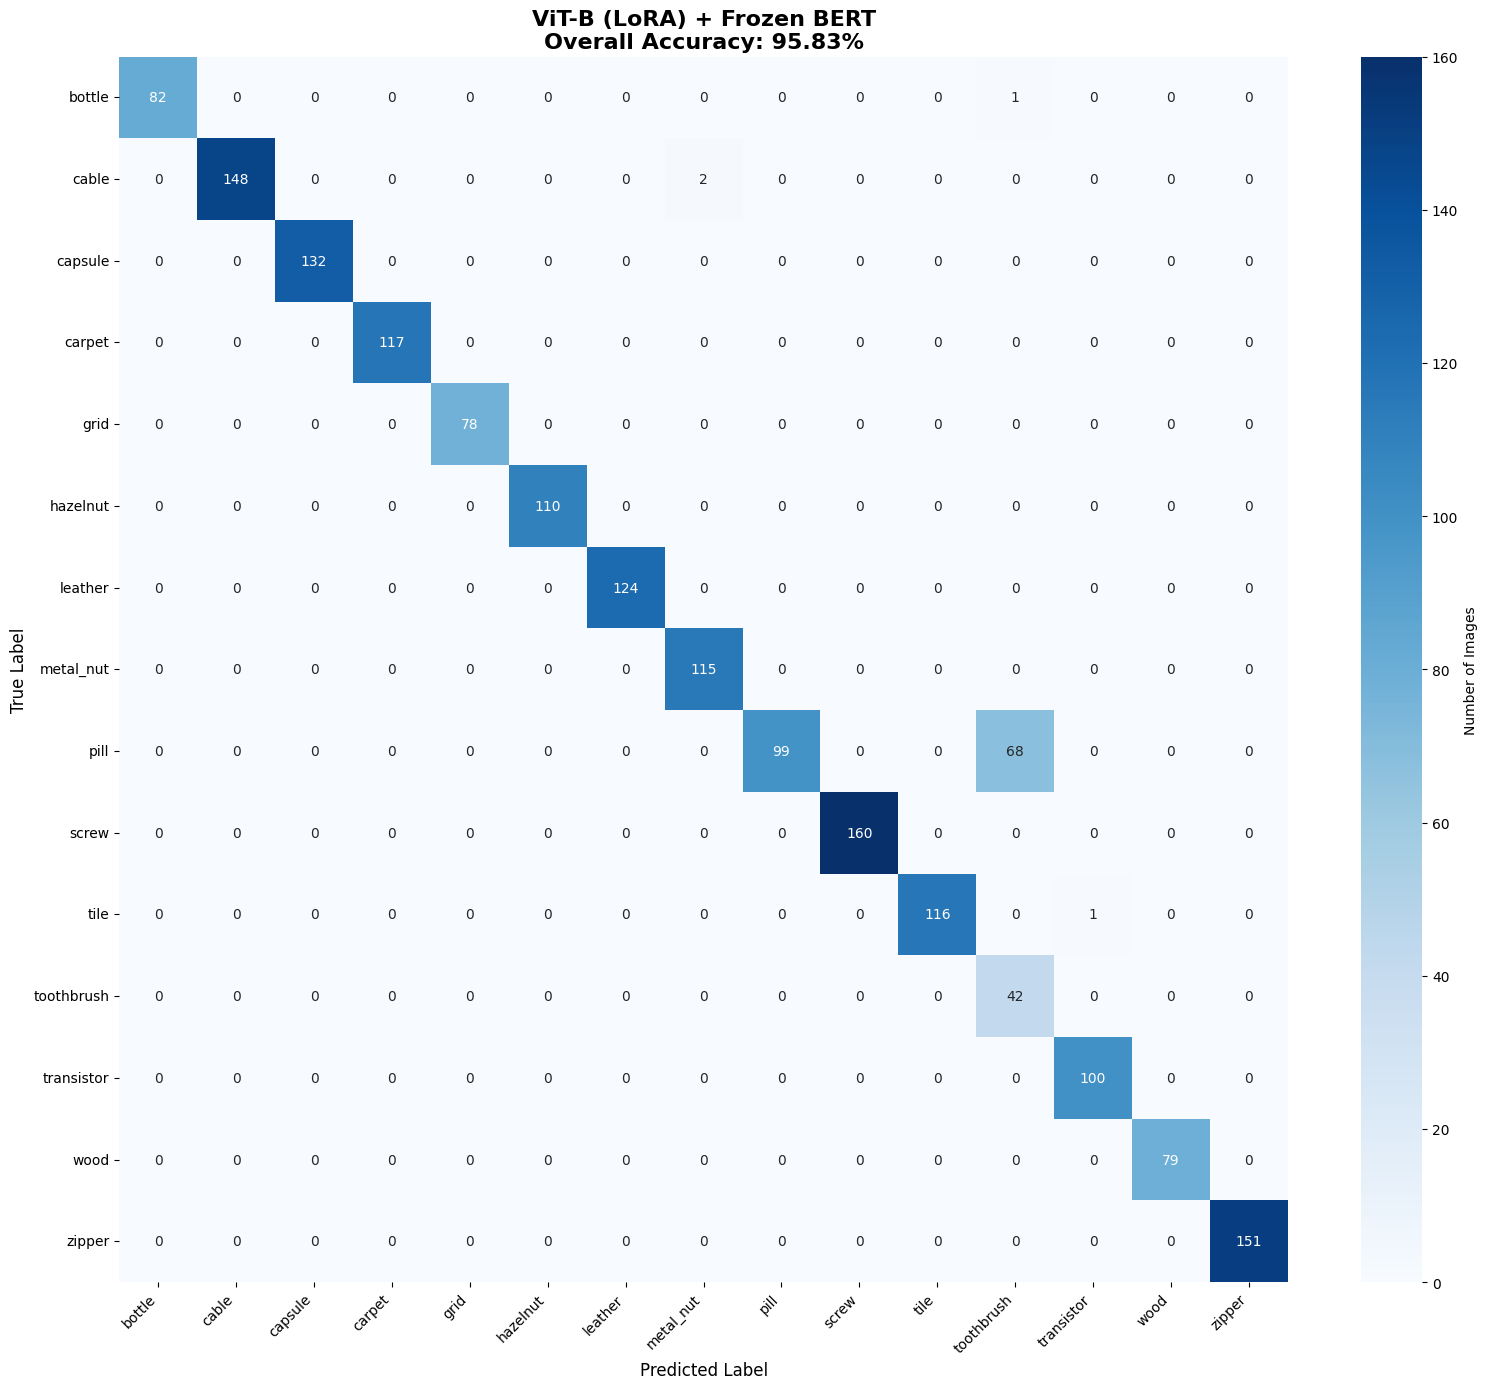


Overall Accuracy: 95.83%
              precision    recall  f1-score   support

      bottle     1.0000    0.9880    0.9939        83
       cable     1.0000    0.9867    0.9933       150
     capsule     1.0000    1.0000    1.0000       132
      carpet     1.0000    1.0000    1.0000       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9829    1.0000    0.9914       115
        pill     1.0000    0.5928    0.7444       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    0.9915    0.9957       117
  toothbrush     0.3784    1.0000    0.5490        42
  transistor     0.9901    1.0000    0.9950       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9583      1725
   macro avg     0.9568    0.9706    0.9508      1725


In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_dl, desc="Evaluating"):
        imgs = imgs.to(DEVICE)
        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)
        logits = feat @ txt_feat.T * logit_scale.exp()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=OBJECTS, digits=4)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Blues",
    cbar_kws={'label': 'Number of Images'}
)

plt.title(f"ViT-B (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nOverall Accuracy: {acc*100:.2f}%")
print(report)